# Ensemble Challenge
Goal: to capture the complexity and nuances around the evolution of the pandemic at various stages and locations.

## Consider the following settings:
1. *Timepoint 1*: May 1st, 2020. Setting: Michigan State at the beginning of the pandemic when masking was the main preventative measure. No vaccines available.
2. *Timepoint 2*: May 1st, 2021. Setting: Michigan State prior to the arrival of the Delta variant. Vaccines available.
3. *Timepoint 3*: December 15th, 2021. Setting: Michigan State during the start of the first Omicron wave.

4. *BONUS*: Consider the same three time points, but change the setting to Louisiana, which had different COVID-19 dynamics compared to the Northern and Northeastern states.

## ...and related questions for each:
1. What is the most relevant data to use for model calibration?
2. What was our understanding of COVID-19 viral mechanisms at the time? For example, early in the pandemic, we didn't know if reinfection was a common occurance, or even possible.
3. What are the parameters related to contagiousness/transmissibility and severity of the dominant strain at the time?
4. What policies were in place for a stated location, and how can this information be incorporated into models? (See https://www.bsg.ox.ac.uk/research/covid-19-government-response-tracker for time series of interventions.)

## For each setting:
1. (a) Take a single model, calibrate it using historical data prior to the given date, and create a 4-week forecast for cases, hospitalizations, and deaths beginning on the given date. (b) Evaluate the forecast using the COVID-19 Forecasting Hub Error Metrics (WIS, MAE). The single model evaluation should be done in the same way as the ensemble.

2. Repeat (1), but with an ensemble of different models.

    a. It is fine to calibrate each model independently and weight naively.
    
    b. It would also be fine to calibrate the ensemble as a whole, assigning weights to the different component models, so that you minimize the error of the ensemble vs. historical data.
    
    c. Use the calibration scores and error metrics computed by the CDC Forecasting Hub. As stated on their [website](https://covid19forecasthub.org/doc/reports/): 
    
    “Periodically, we evaluate the accuracy and precision of the [ensemble forecast](https://covid19forecasthub.org/doc/ensemble/) and component models over recent and historical forecasting periods. Models forecasting incident hospitalizations at a national and state level are evaluated using [adjusted relative weighted interval scores (WIS, a measure of distributional accuracy)](https://arxiv.org/abs/2005.12881), and adjusted relative mean absolute error (MAE), and calibration scores. Scores are evaluated across weeks, locations, and targets. You can read [a paper explaining these procedures in more detail](https://www.medrxiv.org/content/10.1101/2021.02.03.21250974v1), and look at [the most recent monthly evaluation reports](https://covid19forecasthub.org/eval-reports). The final report that includes case and death forecast evaluations is 2023-03-13.” 

3. Produce the forecast outputs in the format specified by the CDC forecasting challenge, including the specified quantiles.

## Data
Use the following data sources:
1. Cases: [Johns Hopkins](https://github.com/CSSEGISandData/COVID-19/blob/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_US.csv), [Reich Lab](https://github.com/reichlab/covid19-forecast-hub/blob/master/data-truth/truth-Incident%20Cases.csv) (pulled from Johns Hopkins, but formatted)

2. Hospitalizations: [HealthData.gov](https://healthdata.gov/Hospital/COVID-19-Reported-Patient-Impact-and-Hospital-Capa/g62h-syeh)

3. Deaths: [Johns Hopkins](https://github.com/reichlab/covid19-forecast-hub/blob/master/data-truth/truth-Incident%20Deaths.csv), [Reich Lab](https://github.com/reichlab/covid19-forecast-hub/blob/master/data-truth/truth-Cumulative%20Deaths.csv)

In [1]:
# Load inital dependencies
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
US_regions = ['US', 'AL', 'AK', 'Skip', 'AZ', 'AR', 'CA', 'Skip 2', 'CO', 'CT', 'DE', 'DC', 'FL', 'GA', 'Skip 3', 
                'HI', 'ID', 'IL', 'IN', 'IA', 'KS', 'KY', 'LA', 'ME', 'MD', 'MA', 'MI', 'MN', 'MS', 'MO', 'MT', 'NE', 
                'NV', 'NH', 'NJ', 'NM', 'NY', 'NC', 'ND', 'OH', 'OK', 'OR', 'PA', 'Skip 4', 'RI', 'SC', 'SD', 'TN', 
                'TX', 'UT', 'VT', 'VA', 'Skip 5', 'WA', 'WV', 'WI', 'WY']
fips_dict = {state: fips for state, fips in zip(US_regions, range(0, 100))}
fips_dict["US"] = "US"

def get_fips(US_region):
    '''This function returns the 1 or 2 digit FIPS code corresponding to the 2-letter state abbreviation.
    
    :param US_state: 2-letter state abbreviation as a string
    :returns: 1 or 2 digit FIPS code as a string
    '''
    return str(fips_dict[US_region])

In [3]:
# Set region and infectious period
US_region = "MI"
fips_code = get_fips(US_region)
infectious_period = 7

# Get incident case data (by county) and sort by date
url = 'https://media.githubusercontent.com/media/reichlab/covid19-forecast-hub/master/data-truth/truth-Incident%20Cases.csv'
raw_cases = pd.read_csv(url)
raw_cases['date'] = pd.to_datetime(raw_cases.date, infer_datetime_format = True)
raw_cases.sort_values(by = 'date', ascending = True, inplace = True)
print(raw_cases)

# Get hosp census data (by state) and sort by date
url = 'https://media.githubusercontent.com/media/reichlab/covid19-forecast-hub/master/data-truth/truth-Incident%20Hospitalizations.csv'
raw_hosp = pd.read_csv(url)
raw_hosp['date'] = pd.to_datetime(raw_hosp.date, infer_datetime_format = True)
raw_hosp.sort_values(by = 'date', ascending = True, inplace = True)
print(raw_hosp)

# Get cumulative death data (by county) and sort by date
url = 'https://media.githubusercontent.com/media/reichlab/covid19-forecast-hub/master/data-truth/truth-Cumulative%20Deaths.csv'
raw_deaths = pd.read_csv(url)
raw_deaths['date'] = pd.to_datetime(raw_deaths.date, infer_datetime_format = True)
raw_deaths.sort_values(by = 'date', ascending = True, inplace = True)
print(raw_deaths)

/var/folders/2d/7nv4mdvn3q51j89prq_8pylw0000gn/T/ipykernel_52565/2542200153.py:8: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  raw_cases = pd.read_csv(url)
/var/folders/2d/7nv4mdvn3q51j89prq_8pylw0000gn/T/ipykernel_52565/2542200153.py:9: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  raw_cases['date'] = pd.to_datetime(raw_cases.date, infer_datetime_format = True)


              date location      location_name  value
0       2020-01-22     1001     Autauga County      0
233290  2020-01-22     6035      Lassen County      0
2642436 2020-01-22    45011    Barnwell County      0
2643574 2020-01-22    45013    Beaufort County      0
2644712 2020-01-22    45015    Berkeley County      0
...            ...      ...                ...    ...
2421663 2023-03-04    39167  Washington County      0
2420525 2023-03-04    39165      Warren County      0
2419387 2023-03-04    39163      Vinton County      0
2417111 2023-03-04    39159       Union County      0
3641599 2023-03-04       US      United States   1932

[3641600 rows x 4 columns]


/var/folders/2d/7nv4mdvn3q51j89prq_8pylw0000gn/T/ipykernel_52565/2542200153.py:16: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  raw_hosp['date'] = pd.to_datetime(raw_hosp.date, infer_datetime_format = True)


            date location  location_name  value
22879 2020-01-01       32         Nevada    132
15087 2020-01-02       32         Nevada    132
22516 2020-01-03       05       Arkansas      0
16863 2020-01-03       32         Nevada    132
23474 2020-01-04       32         Nevada    132
...          ...      ...            ...    ...
22372 2023-06-30       04        Arizona     16
28066 2023-06-30       26       Michigan     27
22547 2023-06-30       24       Maryland     10
17407 2023-06-30       47      Tennessee      8
59329 2023-06-30       US  United States    879

[59330 rows x 4 columns]


/var/folders/2d/7nv4mdvn3q51j89prq_8pylw0000gn/T/ipykernel_52565/2542200153.py:22: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  raw_deaths = pd.read_csv(url)
/var/folders/2d/7nv4mdvn3q51j89prq_8pylw0000gn/T/ipykernel_52565/2542200153.py:23: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  raw_deaths['date'] = pd.to_datetime(raw_deaths.date, infer_datetime_format = True)


              date location      location_name    value
0       2020-01-22     1001     Autauga County        0
233290  2020-01-22     6035      Lassen County        0
2642436 2020-01-22    45011    Barnwell County        0
2643574 2020-01-22    45013    Beaufort County        0
2644712 2020-01-22    45015    Berkeley County        0
...            ...      ...                ...      ...
2421663 2023-03-04    39167  Washington County      247
2420525 2023-03-04    39165      Warren County      646
2419387 2023-03-04    39163      Vinton County       60
2417111 2023-03-04    39159       Union County      117
3641599 2023-03-04       US      United States  1122164

[3641600 rows x 4 columns]


In [50]:
# Select data for the given region
regional_hosp = raw_hosp[raw_hosp["location"] == fips_code]
if fips_code == "US":
    regional_cases = raw_cases[raw_cases["location"] == "US"]
    regional_deaths = raw_deaths[raw_deaths["location"] == "US"]
elif len(fips_code) == 1:
    regional_cases = raw_cases[(raw_cases["location"].astype(str).str.len() == 4.0) & (raw_cases["location"].astype(str).str[:1] == fips_code)]
    regional_deaths = raw_deaths[(raw_deaths["location"].astype(str).str.len() == 4.0) & (raw_deaths["location"].astype(str).str[:1] == fips_code)]
elif len(fips_code) == 2:
    regional_cases = raw_cases[(raw_cases["location"].astype(str).str.len() == 5.0) & (raw_cases["location"].astype(str).str[:2] == fips_code)]
    regional_deaths = raw_deaths[(raw_cases["location"].astype(str).str.len() == 5.0) & (raw_deaths["location"].astype(str).str[:2] == fips_code)]

# Set up DataFrame to hold COVID data and convert incident cases to case census and 
regional_cases["case census"] = 0
regional_cases = regional_cases.reset_index(drop = True)
regional_hosp = regional_hosp.reset_index(drop = True)
regional_hosp = regional_hosp.groupby("date")["value"].sum()
regional_hosp = pd.DataFrame({"hosp_census": regional_hosp})

regional_deaths = regional_deaths.reset_index(drop = True)
regional_deaths = regional_deaths.groupby("date")["value"].sum()
regional_deaths = pd.DataFrame({"cumulative_deaths": regional_deaths})

covid_data_df = {}
covid_data_df["date"] = regional_cases["date"].unique()
covid_data_df["value"] = regional_cases.groupby("date")["value"].sum()
covid_data_df = pd.DataFrame(covid_data_df)
covid_data_df["case_census"] = covid_data_df["value"].rolling(infectious_period, min_periods=1).sum()
covid_data_df = covid_data_df.drop(columns = ["value"])
covid_data_df = covid_data_df.set_index("date")

/var/folders/2d/7nv4mdvn3q51j89prq_8pylw0000gn/T/ipykernel_52565/3751942385.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  regional_cases["case census"] = 0


In [52]:
# Add hosp and death data to covid_data_df
covid_data_df = pd.merge(covid_data_df, regional_hosp, how="inner", left_index=True, right_index=True)
covid_data_df = pd.merge(covid_data_df, regional_deaths, how="inner", left_index=True, right_index=True)
covid_data_df

,case_census,hosp_census,cumulative_deaths
date,,,
2020-06-10,1486.0,0,5880
2020-06-11,1415.0,0,5910
2020-06-12,794.0,0,5915
2020-06-13,881.0,0,5940
2020-06-14,1046.0,0,5943
...,...,...,...
2023-02-28,7456.0,119,41855
2023-03-01,7456.0,97,41855
2023-03-02,7456.0,116,41855


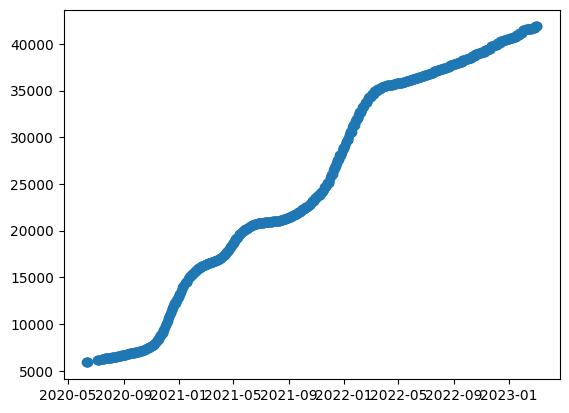

In [53]:
# Reset the index of the DataFrame
# covid_data_df = covid_data_df.reset_index(drop = True)

# Plot the index of the dataframe and the case_census column
# plt.plot(covid_data_df.index, covid_data_df["case_census"], 'o')

# Plot the index of the dataframe and the hosp_census column
# plt.plot(covid_data_df.index, covid_data_df["hosp_census"], 'o')

# Plot the index of the dataframe and the cumulative deaths column
plt.plot(covid_data_df.index, covid_data_df["cumulative_deaths"], 'o')

In [ ]:
filename = US_region + "_case_hospital_death.csv"
covid_data_df.to_csv(filename, index = True, header = True)

In [ ]:
covid_data_df

## Models:
1. You may consider any of the models you have seen in the started kit, or 6-month hackathon and evaluation scenarios.

2. You may search for new models in the literature, or use TA2 model extension/transformation capabilities to modify models already in Terarium.

In [ ]:
# from pyciemss.utils.toronto_hackathon_utils.toronto_ensemble_challenge_utils import get_case_hosp_death_data

In [ ]:
# data = get_case_hosp_death_data("MI", 7)
# data